In [7]:
# Yonatan Juarez, Fall2024 CS677
import os
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [15]:
# 1.1 Data preparation
# We provided an example set of images here, but we encourage you to also take photos with your own camera or smartphone.
# Take two or more photos of the same scene, ensuring that there is enough overlap between consecutive photos for matching 
# features and the viewpoint change is approximately that of rotation only.
images = ["001.jpg", "002.jpg", "003.jpg"]

In [16]:
results_path = os.path.join(os.getcwd(),  "results")
os.makedirs(results_path)

Image 1: 75295 keypoints detected.
Image 2: 67155 keypoints detected.
Image 3: 52663 keypoints detected.


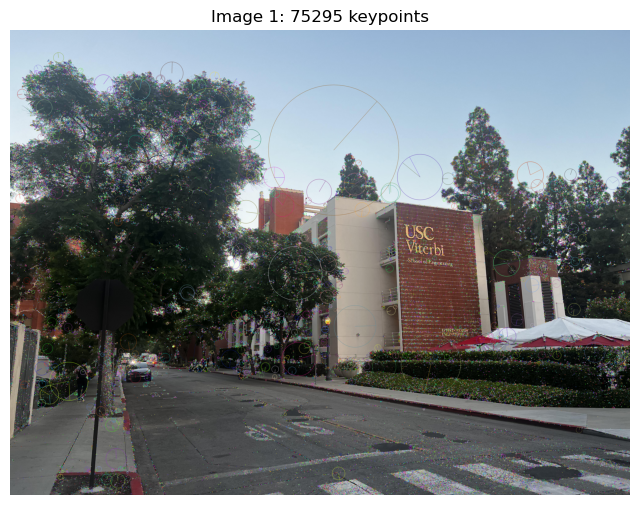

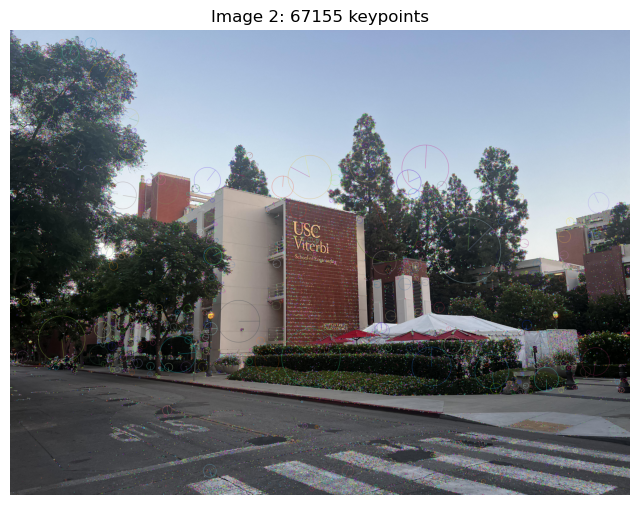

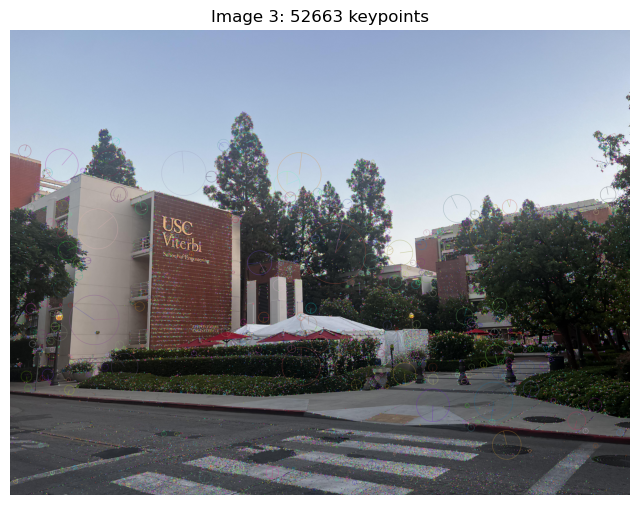

In [18]:
# 1.2 Feature detection
# Load the images using cv.imread(). Convert them to grayscale images. Create a SIFT feature detector. 
# Detect the keypoints on both images and display them with size and orientation using cv.drawKeypoints().
# Load the images using cv.imread()
grayscale_images = []

# Convert them to grayscale images
for img in images:
    grayscale_img = cv.imread(img, cv.COLOR_BGR2GRAY)  # 0 flag loads the image in grayscale
    grayscale_images.append(grayscale_img)

# Create a SIFT feature detector
sift = cv.SIFT_create()

# Detect keypoints and descriptors on all images
keypoints_list = []
descriptors_list = []
for img in grayscale_images:
    keypoints, descriptors = sift.detectAndCompute(img, None)
    keypoints_list.append(keypoints)
    descriptors_list.append(descriptors)

# Display the keypoints on the images using cv.drawKeypoints()
output_images = []
for i, img in enumerate(grayscale_images):
    output_img = cv.drawKeypoints(
        img, 
        keypoints_list[i], 
        None, 
        flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS  # Draw keypoints with size and orientation
    )
    output_images.append(output_img)

    path = os.path.join(results_path, f"{i+1}_keypoints.jpg")
    cv.imwrite(path, output_img)

    # Print number of keypoints detected
    print(f"Image {images[i]}: {len(keypoints_list[i])} keypoints detected.")

# Display the images using matplotlib
for i, output_img in enumerate(output_images):
    plt.figure(figsize=(8, 8))
    plt.imshow(cv.cvtColor(output_img, cv.COLOR_BGR2RGB))
    plt.title(f"Image {i+1}: {len(keypoints_list[i])} keypoints")
    plt.axis('off')
    plt.show()

# plt.show()

Total number of good matches: 9203


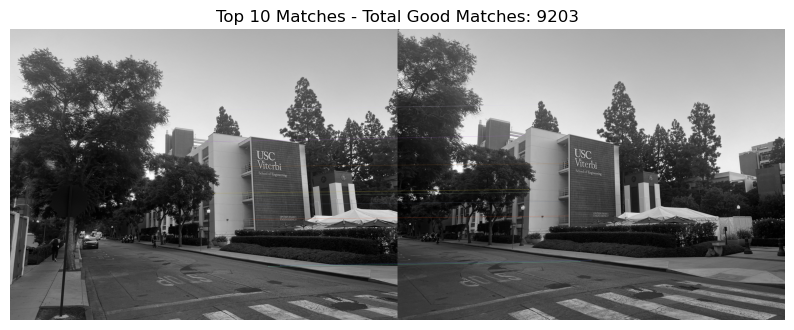

In [21]:
# 1.3 Feature matching
# Create a brute force matcher with cv.BFMatcher(). Use bf.knnMatch to find matches among the descriptors you just detected on the two images. 
# This function returns the top-k matches by filtering out weak matches according to the ratio between the best and the second-best matches. 
# Set k=2 for the ratio test to filter matches, but you can experiment with other k values to achieve the best matching results. Display 
# resulting matches between the two images using cv.drawMatchesKnn()

img1 = cv.imread('001.jpg', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('002.jpg', cv.IMREAD_GRAYSCALE)

# Initialize the SIFT detector
sift = cv.SIFT_create()

# Detect keypoints and descriptors in both images
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Create a BFMatcher object with default params (L2 norm for SIFT)
# bf = cv.BFMatcher(cv.NORM_L2, crossCheck=False)
bf = cv.BFMatcher()

# Find the top-2 matches for each descriptor (k=2)
matches = bf.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:  # Use 0.75 as the ratio for filtering
        good_matches.append([m])

# top-10 matches based on distances
sorted_good_matches = sorted(good_matches, key=lambda x: x[0].distance)
top_10_matches = sorted_good_matches[:10]

# draw top-10 matches
img_matches_10 = cv.drawMatchesKnn(
    img1, kp1, img2, kp2, top_10_matches, None, 
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
# Draw the matches
img_matches = cv.drawMatchesKnn(img1, kp1, img2, kp2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the result
# cv.imshow('Matches', img_matches)

# Save the result image & top-10 image
path = os.path.join(results_path, "matches_knn.jpg")
cv.imwrite(path, img_matches)

path_10 = os.path.join(results_path, "top_10_matches_knn.jpg")
cv.imwrite(path_10, img_matches_10)

print(f"Total number of good matches: {len(good_matches)}")

# Show the image with top 10 matches using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(img_matches_10)
plt.title(f"Top 10 Matches - Total Good Matches: {len(good_matches)}")
plt.axis('off')
plt.show()


In [23]:
#  1.4 Compute homography
# Using the matched features, compute the homography matrix for each pair of consecutive images with RANSAC. 
# Print out the homography matrix. You can use cv.findHomography() for this.
img1 = cv.imread('001.jpg', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('002.jpg', cv.IMREAD_GRAYSCALE)

# Initialize the SIFT detector
sift = cv.SIFT_create()

# Detect keypoints and descriptors
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Create a brute-force matcher object
bf = cv.BFMatcher()

# Find the matches using knnMatch
matches = bf.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Minimum number of matches to compute homography
MIN_MATCH_COUNT = 10

# If we have enough good matches, compute homography
if len(good_matches) > MIN_MATCH_COUNT:
    # Extract the matching keypoints positions from both images
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Compute the homography matrix using cv.findHomography()
    homography_matrix, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)

    # count the number of inliers
    inliers = mask.ravel().tolist()
    n_inliers = np.sum(mask)
    print(f"Total number of inliers: {n_inliers}")

     # Calculate the error between the projected source keypoints and destination keypoints
    errors = []
    for i, m in enumerate(good_matches):
        if inliers[i]:  # Only consider inliers
            projected_pt = cv.perspectiveTransform(src_pts.reshape(-1,1,2), homography_matrix)
            dst_pt = dst_pts[i]
            error = np.linalg.norm(projected_pt - dst_pt)
            errors.append((m, error))

    # Sort the inliers based on error (ascending order)
    errors.sort(key=lambda x: x[1])

    # Get the top-10 inlier matches with the smallest error
    top_10_matches = [e[0] for e in errors[:10]]

    # Print the homography matrix
    print("Homography Matrix:")
    print(homography_matrix)
    
    # Display the matches (all inliers)
    img_matches = cv.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    cv.imwrite(os.path.join(results_path,"Matches.jpg"), img_matches)

    # dispaly the top-10 matches based on smallest error
    img_top_10_matches = cv.drawMatches(img1, kp1, img2, kp2, top_10_matches, None,
                                            flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    # Save the top-10 matches result
    cv.imwrite(os.path.join(results_path,"Top_10_Inlier_Matches.jpg"), img_top_10_matches)
else:
    print(f"Not enough matches found - {len(good_matches)}/{MIN_MATCH_COUNT}")




Total number of inliers: 4418
Homography Matrix:
[[ 1.44303595e+00 -4.65997118e-02 -1.29217155e+03]
 [ 2.11302610e-01  1.27158122e+00 -5.54760595e+02]
 [ 1.07425998e-04  5.98849601e-06  1.00000000e+00]]


In [29]:
# 1.5 Stitch into a panoroma
# Before stitching the images to compose a panorama, you need to determine the size of the final stitched image.
# Since the panorama is larger than each individual image, we need to define a rectangle that covers all warped images. 
# We provide the code snippet below for reference. In this code, cv.perspectiveTransform() is used to apply a per- spective 
# transformation to a set of points, allowing us to calculate the minimum and maximum coordinates (min x, min y, max x, max y)
# to define the size of the output stitched image.
# Now, you can proceed to stitch the images. First, select an image as an anchor and transform other images onto this 
# anchor image. The transformation between any image and this anchor image is the composition of a series of homographies. 
# Compute the transformations and map all other images onto the anchor image. You can use the cv.warpPerspective() function to warp 
# individual images img to the anchor image perspective using a homography matrix H. Example usage:
# warped_img = cv.warpPerspective(img, H, (width, height))
# Note that, by default, this function does bilinear interpolation to calculate the pixel color values for the warped pixels 
# (there is an option to use nearest neighbor instead but we recommend using the default).
# As you warp each image, place it onto the panorama canvas (i.e., the empty ”output” we defined before). The basic logic 
# is to layer the images such that latter images are placed on top of former ones. This means that as you add each warped image 
# to the panorama, it will overlap and blend with the previous images.
# After you obtain the panorama, display it along with each transformed image.


# Load the images
images = [cv.imread('001.jpg'), cv.imread('002.jpg'), cv.imread('003.jpg')]

# Convert images to grayscale
grayscale_images = [cv.cvtColor(image, cv.COLOR_BGR2GRAY) for image in images]

# Initialize SIFT detector
sift = cv.SIFT_create()

# Detect keypoints and descriptors
keypoints_descriptors = [sift.detectAndCompute(image, None) for image in grayscale_images]
keypoints = [kp for kp, des in keypoints_descriptors]
descriptors = [des for kp, des in keypoints_descriptors]

# Brute force matcher
bf = cv.BFMatcher()
matches = [bf.knnMatch(descriptors[i], descriptors[i + 1], k=2) for i in range(len(descriptors) - 1)]

# Apply ratio test for good matches
good_matches = []
for match_set in matches:
    good = []
    for m, n in match_set:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    good_matches.append(good)

# Compute homographies between consecutive images
homographies = []
for i, good in enumerate(good_matches):
    if len(good) > 10:  # Minimum matches needed
        src_pts = np.float32([keypoints[i][m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints[i + 1][m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        H, _ = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
        homographies.append(H)
    else:
        print(f"Not enough matches between image {i} and image {i+1}")

# Cumulative homographies relative to the first image (identity matrix for the first image)
cumulative_homographies = [np.eye(3)]
for i in range(1, len(homographies) + 1):
    cumulative_homographies.append(cumulative_homographies[i - 1] @ homographies[i - 1])

# Define the size of the final stitched panorama
min_x = min_y = max_x = max_y = 0
for i in range(len(images)):
    h, w = images[i].shape[:2]
    corners = np.array([[0, 0], [w, 0], [w, h], [0, h]], dtype=np.float32).reshape(-1, 1, 2)
    transformed_corners = cv.perspectiveTransform(corners, cumulative_homographies[i])

    min_x = min(min_x, transformed_corners[:, 0, 0].min())
    min_y = min(min_y, transformed_corners[:, 0, 1].min())
    max_x = max(max_x, transformed_corners[:, 0, 0].max())
    max_y = max(max_y, transformed_corners[:, 0, 1].max())

# Calculate the size of the final stitched image
output_width = int(max_x - min_x)
output_height = int(max_y - min_y)

# Offset to handle negative coordinates
offset_matrix = np.array([[1, 0, -min_x],
                          [0, 1, -min_y],
                          [0, 0, 1]], dtype=np.float32)

# Create an empty output panorama image
panorama = np.zeros((output_height, output_width, 3), dtype=np.uint8)

# Warp and place each image onto the panorama
for i, img in enumerate(images):
    # Apply cumulative homography and offset
    homography = offset_matrix @ cumulative_homographies[i]
    warped_img = cv.warpPerspective(img, homography, (output_width, output_height))

    # Place the warped image onto the panorama (use max blending for overlapping areas)
    mask = np.any(warped_img > 0, axis=2)  # Mask of non-black pixels in the warped image
    panorama[mask] = warped_img[mask]

# Save the final panorama
cv.imwrite(os.path.join(results_path,"Panorama.jpg"), panorama)


True